<Figure size 640x480 with 0 Axes>

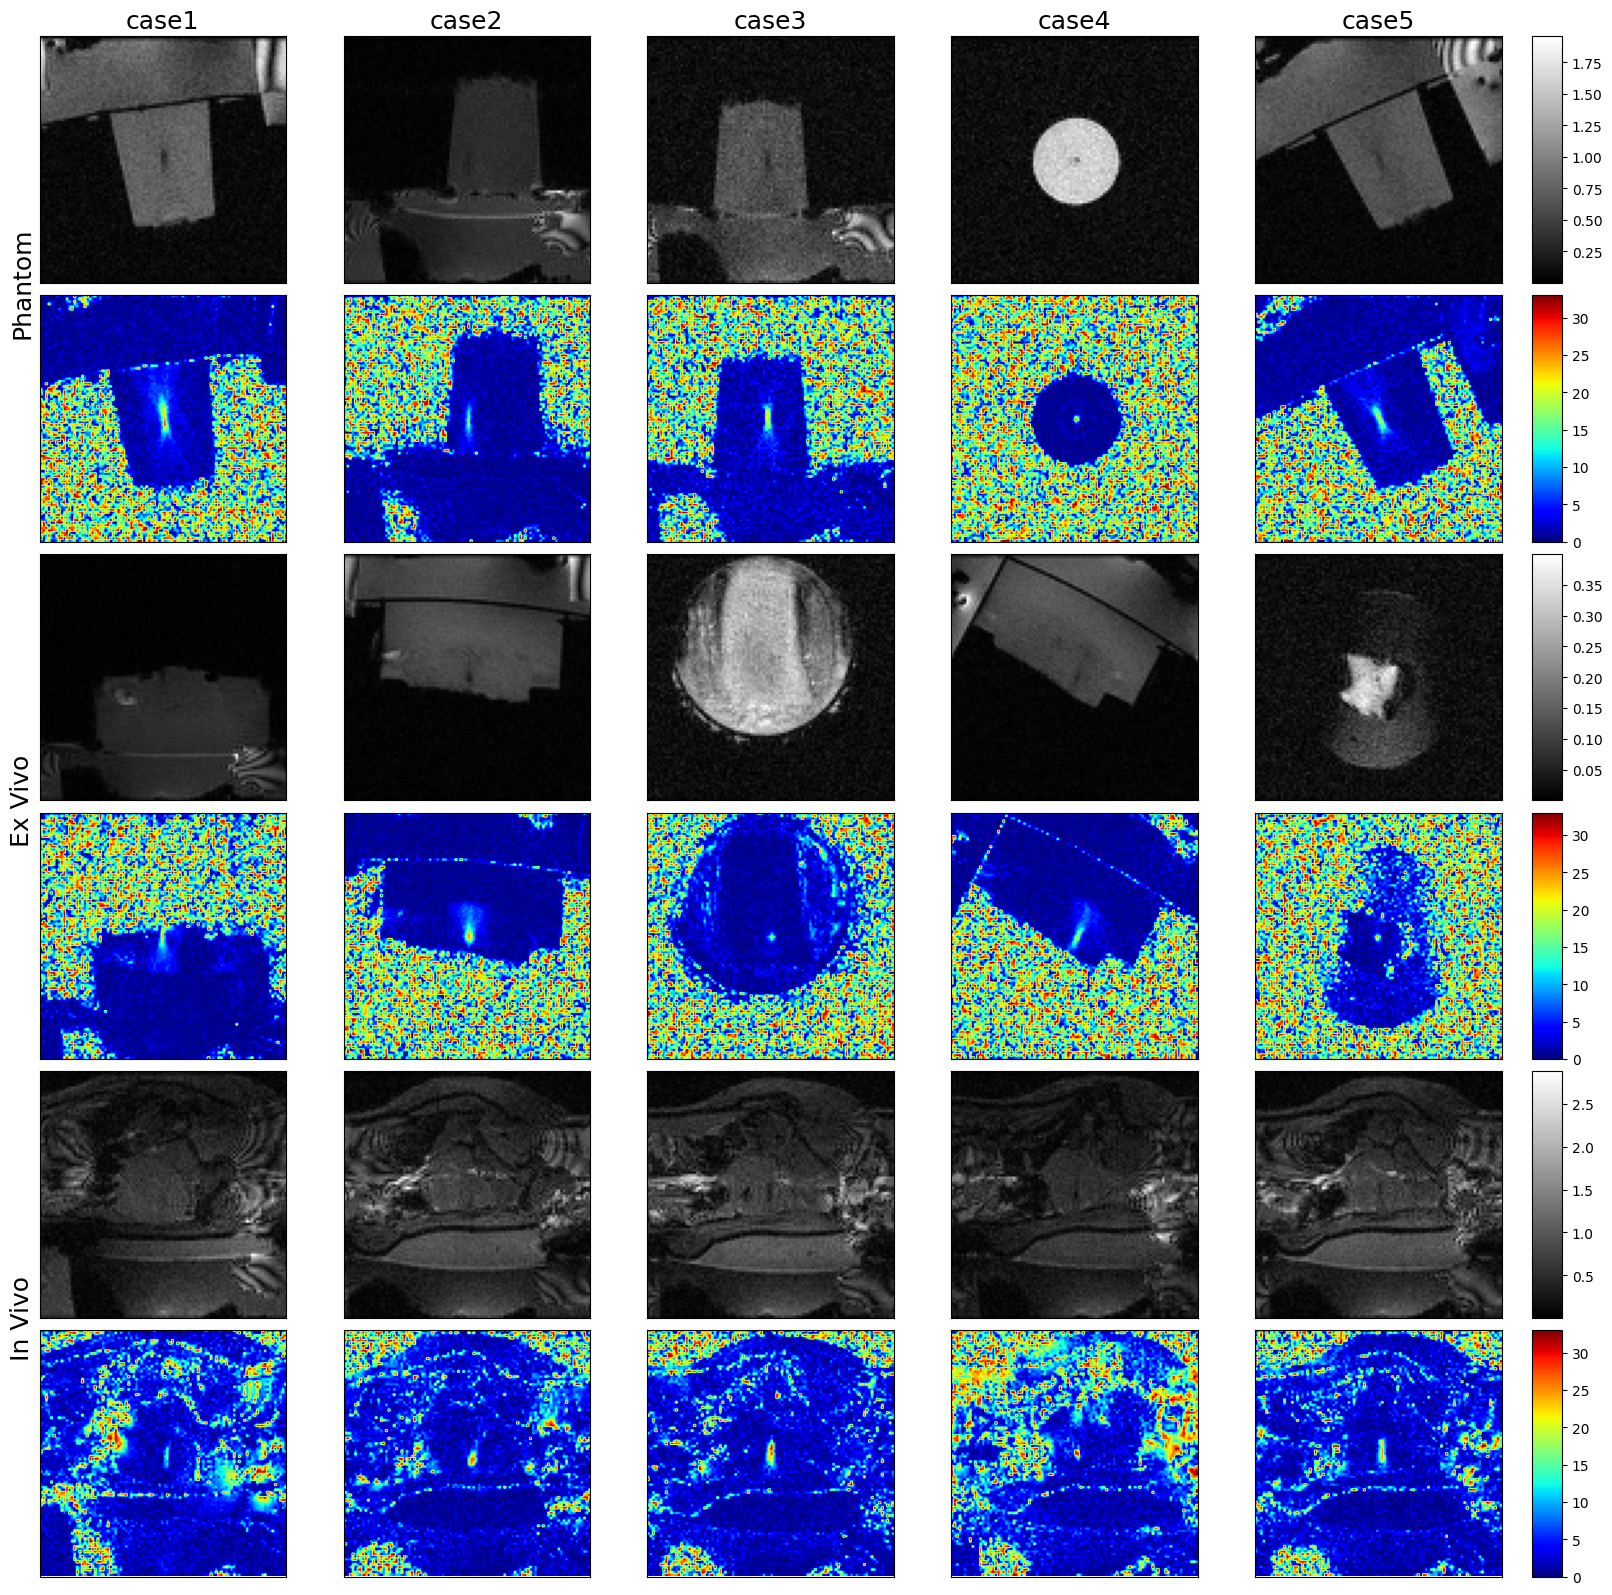

In [53]:
"""Show Dataset"""

from fastmrt.data.dataset import SliceDataset, VolumeDataset
from fastmrt.data.mask import EquiSpacedMaskFunc
from fastmrt.data.augs import ComplexAugs, IdentityAugs
from fastmrt.data.prf import PrfFunc, PrfHeader
from fastmrt.data.transforms import FastmrtDataTransform2D
from fastmrt.utils.trans import real_tensor_to_complex_np as rt2cn
from fastmrt.utils.normalize import denormalize
from fastmrt.utils.fftc import ifft2c_numpy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import torch

# assign data root
data_root  = {
    'phantom': '../../Datasets/FastMRT Dataset V5.0/phantom/train/source',
    'exvivo': '../../Datasets/FastMRT Dataset V5.0/exvivo/train/source',
    'invivo': '../../Datasets/FastMRT Dataset V5.0/invivo/train/source'
}

# define mask function
mask_func = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=4)

# define augmentation function
# augs_func = ComplexAugs(96, 96, True, objs=["amp"])
augs_func = IdentityAugs()

# define prf function
prf_header = PrfHeader(B0=3, gamma=42.576, alpha=0.01, TE=12)
prf_func = PrfFunc(prf_header)

# define data transforms
transforms = FastmrtDataTransform2D(mask_func=mask_func, prf_func=prf_func, aug_func=augs_func, data_format='RF')

# define dataset
slice_dataset = {}
for key, val in data_root.items():
    slice_dataset.update({key: SliceDataset(root=[val], transform=lambda x: x)})

# save tmap
# import os
# save_dir = "./tmaps"
# os.makedirs(save_dir, exist_ok=True)
# offset = 0
# for key, val in slice_dataset.items():
#     os.makedirs(os.path.join(save_dir, key), exist_ok=True)
#     for idx, case in enumerate(val[offset:]):
#         tmap = prf_func(ifft2c_numpy(case["kspace"]), ifft2c_numpy(case["kspace_ref"]))
#         plt.clf()
#         plt.ioff()
#         plt.imshow(tmap, cmap="jet", vmin=0, vmax=70)
#         name = idx+offset
#         plt.savefig(os.path.join(save_dir, key, f"{name}.png"))


cases = {
    'phantom': [7,191,816,802,1024],
    'exvivo': [8,17,367,242,448],
    'invivo': [41,107,265,307,400]
}
samples = dict()
for key, val in slice_dataset.items():
    case_samples = []
    for case_idx in cases[key]:
        kspace = val[case_idx]["kspace"]
        kspace_ref = val[case_idx]["kspace_ref"]
        image = ifft2c_numpy(kspace)
        image_ref = ifft2c_numpy(kspace_ref)
        tmap = prf_func(image, image_ref, offset=0)
        case_samples.append([image, tmap])
    samples.update({key: case_samples})


# draw
plt.clf()
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(wspace=0.01, hspace=0.05)
gs = GridSpec(6, len(cases["phantom"])+1, figure=fig, width_ratios=[1] * len(cases["phantom"]) + [0.1], height_ratios=[1] * 6)

row_orders = ["phantom", "exvivo", "invivo"]
col_orders = list(range(len(cases["phantom"])))
row_names = {
    "phantom": "Phantom", 
    "exvivo": "Ex Vivo",
    "invivo": "In Vivo" 
}
for row_idx, row in enumerate(row_orders):
    for col_idx, col in enumerate(col_orders):
        ax1 = fig.add_subplot(gs[row_idx * 2, col_idx])
        ax2 = fig.add_subplot(gs[row_idx * 2+1, col_idx])
        sample = samples[row][col]
        im1 = ax1.imshow(np.abs(sample[0]), cmap="gray")
        im2 = ax2.imshow(np.abs(sample[1]), vmin=0, vmax=33, cmap="jet")

        if row_idx == 0:
            ax1.set_title(f"case{col_idx+1}", fontsize=18)
        if col_idx == 0:
            ax1.set_ylabel(row_names[row_orders[row_idx]], y=-0, fontsize=18)

        # clear tricks
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        
    cax1 = fig.add_subplot(gs[row_idx * 2, -1])
    cax2 = fig.add_subplot(gs[row_idx * 2+1, -1])
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar2 = plt.colorbar(im2, cax=cax2)
plt.show()


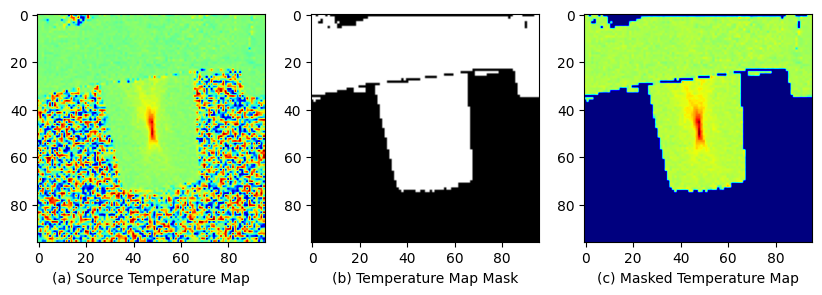

In [4]:
"""Show Temperature Mask"""
import os
import h5py
from fastmrt.utils.fftc import ifft2c_numpy

file_name = "../../Datasets/FastMRT Dataset V5.0/phantom/train/source/t01001.h5"

with h5py.File(file_name, "r") as hf:
    header = dict(hf.attrs)
    kspace = hf["kspace"][()].transpose()
    tmap_masks = hf["tmap_masks"][()].transpose() \
        if hf["tmap_masks"][()].shape is not None else None

image = ifft2c_numpy(np.squeeze(kspace[8, 0, 0, :, :]))
image_ref = ifft2c_numpy(np.squeeze(kspace[0, 0, 0, :, :]))
tmap = prf_func(image, image_ref)
tmap_masks = tmap_masks.squeeze()

# draw
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.imshow(tmap, cmap="jet")
ax1.set_xlabel("(a) Source Temperature Map")
ax2.imshow(tmap_masks, cmap="gray")
ax2.set_xlabel("(b) Temperature Map Mask")
ax3.imshow(tmap * tmap_masks, cmap="jet")
ax3.set_xlabel("(c) Masked Temperature Map")
plt.show()


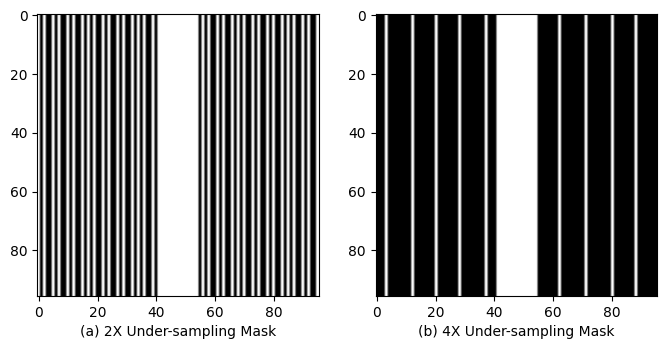

In [5]:
"""Show Under-Sampling Mask"""

from fastmrt.data.mask import EquiSpacedMaskFunc
from fastmrt.data.mask import apply_mask
mask_func2 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=2)
mask_func4 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=4)

image = np.ones([96, 96])
image_2, _, _ = apply_mask(image, mask_func2)
image_4, _, _ = apply_mask(image, mask_func4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image_2, cmap="gray")
ax1.set_xlabel("(a) 2X Under-sampling Mask")
ax2.imshow(image_4, cmap="gray")
ax2.set_xlabel("(b) 4X Under-sampling Mask")
plt.show()

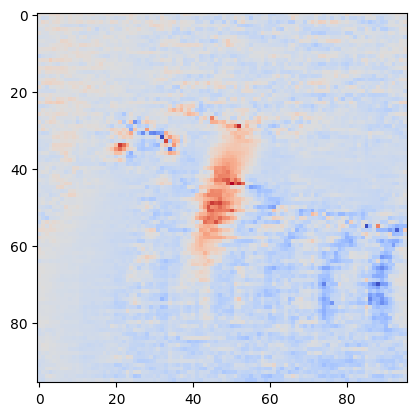

In [74]:
"""Show FastMRI Transfer Learning Dataset Samples"""

from fastmrt.pretrain.mri_data import SliceDataset
from fastmrt.pretrain.transforms import FastmrtPretrainTransform, FastmriPreprocessingTransform, SimuFocusGaussian
from fastmrt.utils.fftc import ifft2c_numpy, fft2c_numpy
import albumentations as A
from fastmrt.utils.seed import temp_seed
from typing import Tuple, Dict
from fastmrt.data.mask import EquiSpacedMaskFunc
from fastmrt.data.mask import apply_mask

def crop(kspace):
    center_crop_func = A.CenterCrop(224, 224)
    random_crop_func = A.RandomCrop(96, 96)
    image = ifft2c_numpy(kspace, fftshift_dim=(-2, -1))
    center_cropped_image = center_crop_func(image=image)["image"]
    random_cropped_image = random_crop_func(image=center_cropped_image)["image"]
    cropped_kspace = fft2c_numpy(random_cropped_image, fftshift_dim=(-2, -1))
    return image, cropped_kspace, center_cropped_image, random_cropped_image

class TempSimuFocusGaussian(SimuFocusGaussian):

    def __call__(
        self,
        shape,
    ):
        delta_phis = np.append(np.sort(np.random.rand(self.frame_num - self.cooling_frame_num)),
                               np.abs(np.sort(np.random.rand(self.cooling_frame_num)) * 0.5 - 1)) * self.max_delta_phi

        gaussian_mask, simufocus_mask = self.generate_simulated_focus(shape)
        return {
            "delta_phis": delta_phis,
            "gaussian_mask": gaussian_mask,
            "simufocus_mask": simufocus_mask,
        }

    def generate_simulated_focus(
            self,
            mask_size: Tuple[int, int],
    ):
        sigma1 = 0.1
        sigma2 = sigma1 * (self.sigma_scale_limit[0] + np.random.rand() *
                           (self.sigma_scale_limit[1] - self.sigma_scale_limit[0]))
        inv_A = 1 / (sigma1 ** 2)
        inv_B = 1 / (sigma2 ** 2)
        inv_C = 0
        gaussian_mask = self.gaussian_map(mask_size, mask_size[0] // 2, mask_size[1] // 2,
                                          inv_A, inv_B, inv_C)
        return gaussian_mask, self.rotate_func(image=gaussian_mask)["image"]

class TempFastmrtPretrainTransform(FastmrtPretrainTransform):
    
    def __init__(
            self,
            simufocus_type: str = "gaussian",
            use_random_seed: bool = True,
            frame_num: int = 11,
            cooling_time_rate: float = 0.2,
            max_delta_temp: float = 30,
    ):
        super(TempFastmrtPretrainTransform, self).__init__()
        self.simufocus_transform = TempSimuFocusGaussian(frame_num=frame_num,
                                                        cooling_time_rate=cooling_time_rate,
                                                        max_delta_temp=max_delta_temp)

    def __call__(
            self,
            data: Dict
    ):
        seed = None if self.use_random_seed is True else tuple(map(ord, data["fname"]))
        image = ifft2c_numpy(data["kspace"], fftshift_dim=(-2, -1))
        with temp_seed(seed):
            simulated_data = self.simufocus_transform(data["kspace"].shape)
            interface_data = self.transform_interface(simulated_data, image)
        interface_data["metainfo"].update({
            "file_name": data["fname"],
            "slice_idx": data["dataslice"],
            "gaussian_mask": simulated_data["gaussian_mask"],
            "simufocus_mask": simulated_data["simufocus_mask"],
        })
        return interface_data

## 1. instantiation
data_path = "../../pt_Datasets/val"
dataset = SliceDataset(root=data_path, challenge="singlecoil", transform=lambda x: x)
transforms = TempFastmrtPretrainTransform()
mask_func4 = EquiSpacedMaskFunc(center_fraction=0.15, acceleration=4)


## 2. obtain a sample
data_idx = 15
sample = dataset[data_idx]
with temp_seed(0):
    image, cropped_kspace, center_cropped_image, random_cropped_image = crop(sample["kspace"])
    preprocessed_sample = {
                "kspace": cropped_kspace,
                "fname": sample["fname"],
                "dataslice": sample["dataslice"]
            }
    input_sample = transforms(preprocessed_sample)
simu_image = ifft2c_numpy(input_sample["kspace"], fftshift_dim=(-2, -1))
tmap_before_simu = prf_func(random_cropped_image, random_cropped_image)
tmap_after_simu = prf_func(simu_image, random_cropped_image)
under_sampling_simu_image = ifft2c_numpy(apply_mask(input_sample["kspace"], mask_func4)[0], fftshift_dim=(-2, -1))
# under_sampling_simu_image = ifft2c_numpy(apply_mask(slice_dataset["phantom"][0]["kspace"], mask_func4)[0], fftshift_dim=(-2, -1))

show_sample = {
    "before":{
        "amp": np.abs(random_cropped_image),
        "phs": np.angle(random_cropped_image),
        "tmap": tmap_before_simu,
    },
    "after":{
        "amp": np.abs(simu_image),
        "phs": np.angle(simu_image),
        "tmap": tmap_after_simu,
    }
}

# 3. draw single image
'''
 one of :
 `source_image`,
 `center_cropped_image`,
 `random_cropped_image`,
 `simu_image`,
 `tmap_before_simu`,
 `tmap_after_simu`
'''
obj = "simu_image"
plt.clf()
if obj == "source_image":
    plt.imshow(np.abs(image))
elif obj == "center_cropped_image":
    plt.imshow(np.abs(center_cropped_image))
elif obj == "random_cropped_image":
    plt.imshow(np.angle(random_cropped_image), cmap="coolwarm")
elif obj == "simu_image":
    plt.imshow(np.angle(simu_image), cmap="coolwarm")
elif obj == "tmap_before_simu":
    plt.imshow(tmap_before_simu, cmap="jet")
elif obj == "tmap_after_simu":
    plt.imshow(tmap_after_simu, cmap="jet")
elif obj == "gaussian_mask":
    plt.imshow(input_sample["metainfo"]["gaussian_mask"], cmap="gray")
elif obj == "simufocus_mask":
    plt.imshow(input_sample["metainfo"]["simufocus_mask"], cmap="gray")
elif obj == "under_sampling_simu_image":
    plt.imshow(np.angle(under_sampling_simu_image), cmap="coolwarm")
plt.show() 

## 4. draw compare images
# plt.clf()
# fig = plt.figure(figsize=(12, 17))
# fig.subplots_adjust(wspace=0.01, hspace=0.05)
# gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 0.1], height_ratios=[1, 1, 1])
# row_orders = ["amp", "phs", "tmap"]
# col_orders = ["before", "after"]
# row_names = {
#     "amp": "Amplitude", 
#     "phs": "Phase",
#     "tmap": "Temperature Map" 
# }
# col_names = {
#     "before": "Before Simulation",
#     "after": "After Simulation"
# }
# cmap = ["gray", "coolwarm", "jet"]
# for row_idx, row in enumerate(row_orders):
#     for col_idx, col in enumerate(col_orders):
#         ax = fig.add_subplot(gs[row_idx, col_idx])
#         im = ax.imshow(show_sample[col][row], cmap=cmap[row_idx])

#         if row_idx == 0:
#             ax.set_title(col_names[col], fontsize=18)
#         if col_idx == 0:
#             ax.set_ylabel(row_names[row], fontsize=18)

#         # clear tricks
#         ax.set_xticks([])
#         ax.set_yticks([])
        
#     cax = fig.add_subplot(gs[row_idx, -1])
#     cbar = plt.colorbar(im, cax=cax)
# plt.show()

../../Datasets/diffusion-augs-samples/hdf5\exvivo\train\source
../../Datasets/diffusion-augs-samples/hdf5\invivo\train\source
../../Datasets/diffusion-augs-samples/hdf5\phantom\train\source


<Figure size 640x480 with 0 Axes>

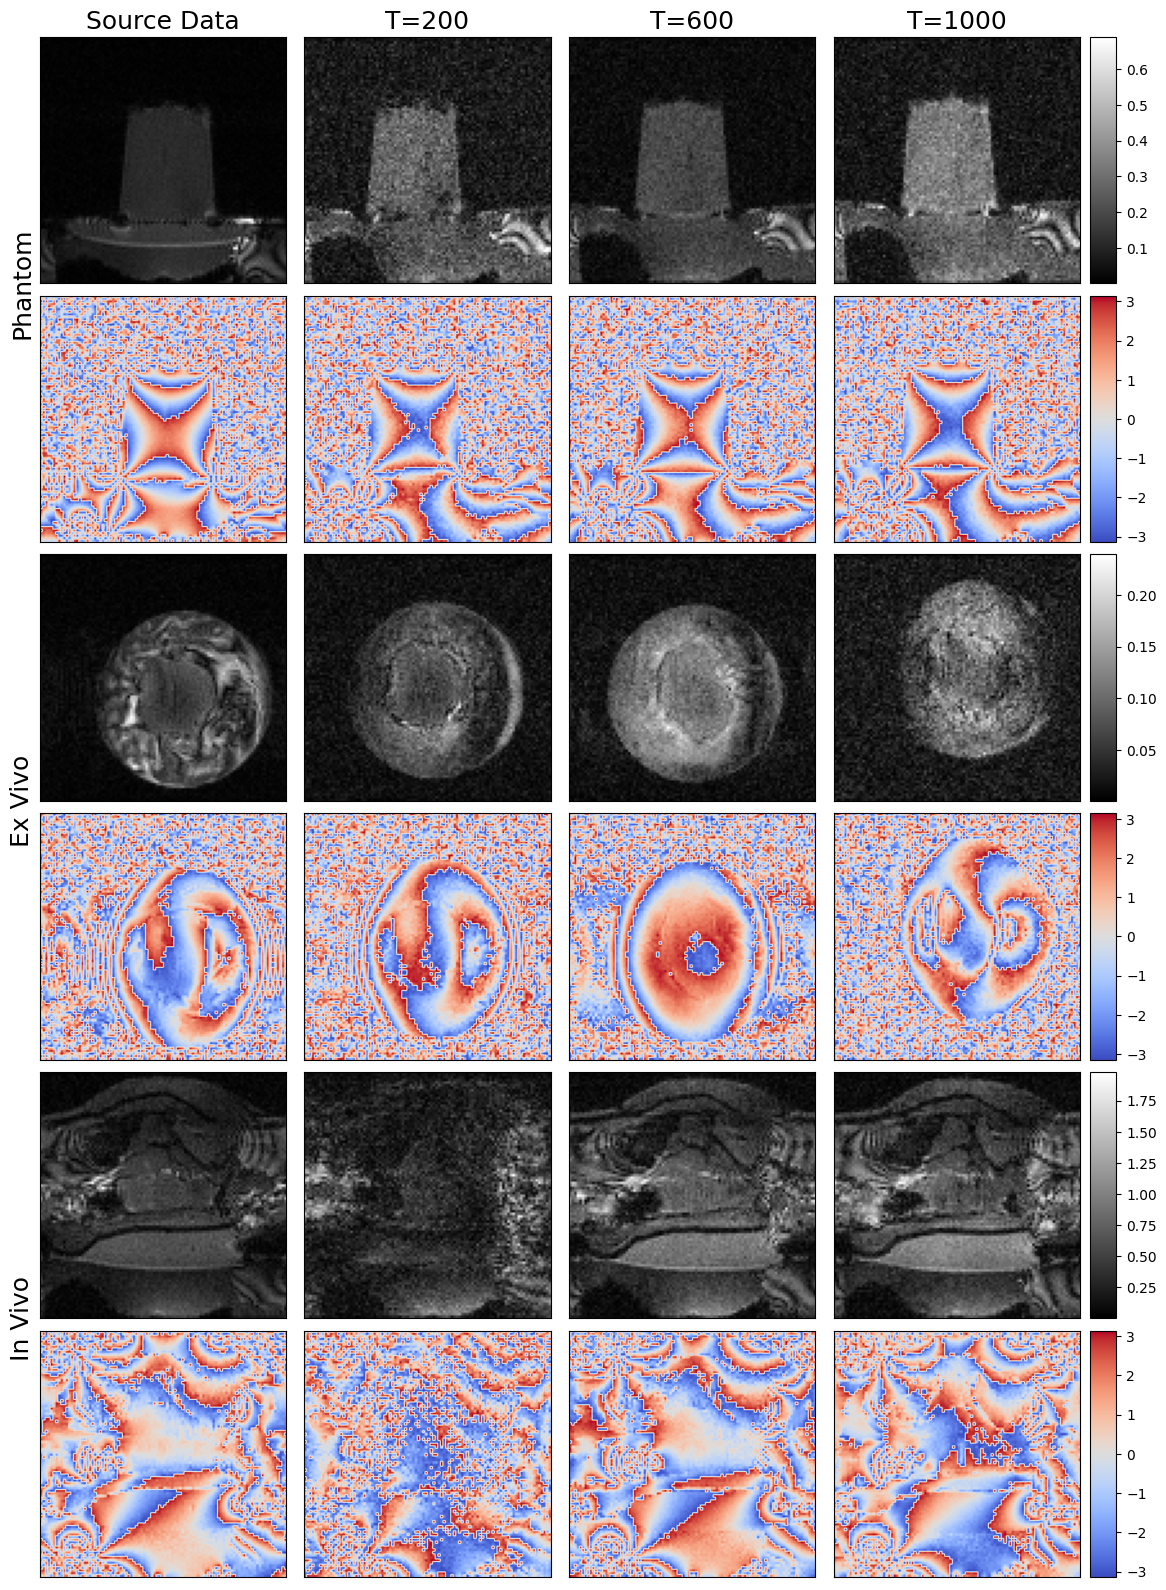

In [64]:
"""Show Diffusion-Auged Datasets"""
from fastmrt.data.dataset import SliceDataset
from fastmrt.utils.fftc import ifft2c_numpy
import os

# config
data_dir = "../../Datasets/diffusion-augs-samples/hdf5"
sample_idx = {
    "phantom": {
        "source": 400,
        "datas_T200_num1000": 0,
        "datas_T600_num1000": 100,
        "datas_T1000_num1000": 0
    },
    "exvivo": {
        "source": 800,
        "datas_T200_num1000": 0,
        "datas_T600_num1000": 100,
        "datas_T1000_num1000": 200
    },
    "invivo": {
        "source": 100,
        "datas_T200_num1000": 0,
        "datas_T600_num1000": 0,
        "datas_T1000_num1000": 0
    },
}
row_orders = ["phantom", "exvivo", "invivo"]
col_orders = ["source", "datas_T200_num1000", "datas_T600_num1000", "datas_T1000_num1000"]

# read augmented data
dataset, samples = {}, {}
for data_type in os.listdir(data_dir):
    temp_dataset, temp_samples = {}, {}
    for i, T in enumerate(os.listdir(os.path.join(data_dir, data_type))):
        temp_dataset.update({
            T: SliceDataset(os.path.join(data_dir, data_type, T), transform=lambda x: x)
        })
        temp_samples.update({
            T: ifft2c_numpy(temp_dataset[T][sample_idx[data_type][T]]["kspace"])
        })
    dataset.update({data_type: temp_dataset})
    samples.update({data_type: temp_samples})

# read source data
source_data_dir = "../../Datasets/FastMRT Dataset V5.0"
for data_type in os.listdir(source_data_dir):
    dataset[data_type].update({"source": SliceDataset(os.path.join(source_data_dir, data_type, "train", "source"), transform=lambda x: x)})
    samples[data_type].update({"source": ifft2c_numpy(dataset[data_type]["source"][sample_idx[data_type]["source"]]["kspace"])})

# draw
plt.clf()
fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(wspace=0.01, hspace=0.05)
gs = GridSpec(6, 5, figure=fig, width_ratios=[1, 1, 1, 1, 0.1], height_ratios=[1] * 6)

row_names = {
    "phantom": "Phantom", 
    "exvivo": "Ex Vivo",
    "invivo": "In Vivo" 
}
col_names = {
    "source": "Source Data",
    "datas_T200_num1000": "T=200",
    "datas_T600_num1000": "T=600",
    "datas_T1000_num1000": "T=1000",
}
for row_idx, row in enumerate(row_orders):
    for col_idx, col in enumerate(col_orders):
        ax1 = fig.add_subplot(gs[row_idx * 2, col_idx])
        ax2 = fig.add_subplot(gs[row_idx * 2+1, col_idx])
        sample = samples[row][col]
        im1 = ax1.imshow(np.abs(sample), cmap="gray")
        im2 = ax2.imshow(np.angle(sample), cmap="coolwarm")

        if row_idx == 0:
            ax1.set_title(col_names[col], fontsize=18)
        if col_idx == 0:
            ax1.set_ylabel(row_names[row], y=-0, fontsize=18)

        # clear tricks
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        
    cax1 = fig.add_subplot(gs[row_idx * 2, -1])
    cax2 = fig.add_subplot(gs[row_idx * 2+1, -1])
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar2 = plt.colorbar(im2, cax=cax2)
plt.show()



In [70]:
"""Save Diffusion-Augs Datasets as PNG"""
import os
from fastmrt.data.dataset import SliceDataset
from fastmrt.utils.fftc import ifft2c_numpy
import cv2 as cv

source_path = "../../Datasets/FastMRT Dataset V5.0/"
target_path = "../../Datasets/diffusion-augs-samples/source"

for data_type in os.listdir(source_path):
    sub_source_path = os.path.join(source_path, data_type, "train")
    sub_target_path = os.path.join(target_path, data_type)
    os.makedirs(sub_target_path, exist_ok=True)
    for data_type_2 in os.listdir(sub_source_path):
        if data_type_2 == "augmented":
            continue
        sub_sub_source_path = os.path.join(sub_source_path, data_type_2)
        sub_sub_target_path_phs = os.path.join(sub_target_path, data_type_2, "phs")
        sub_sub_target_path_amp = os.path.join(sub_target_path, data_type_2, "amp")
        os.makedirs(sub_sub_target_path_phs, exist_ok=True)
        os.makedirs(sub_sub_target_path_amp, exist_ok=True)

        dataset = SliceDataset(os.path.join(sub_source_path, data_type_2), transform=lambda x: x)
        for sample in dataset:
            name = f'{sample["metainfo"]["file_name"][-9:-3]}_' \
                    f'f{sample["metainfo"]["frame_idx"]:02d}' \
                    f's{sample["metainfo"]["slice_idx"]:02d}' \
                    f'c{sample["metainfo"]["coil_idx"]:02d}.png'
            image = ifft2c_numpy(sample["kspace"])
            phs = np.angle(image)
            amp = np.abs(image)
            phs = (phs - np.min(phs)) / (np.max(phs) - np.min(phs)) * 255
            amp = (amp - np.min(amp)) / (np.max(amp) - np.min(amp)) * 255
            cv.imwrite(os.path.join(sub_sub_target_path_phs, name), phs.astype(np.uint8))
            cv.imwrite(os.path.join(sub_sub_target_path_amp, name), amp.astype(np.uint8))



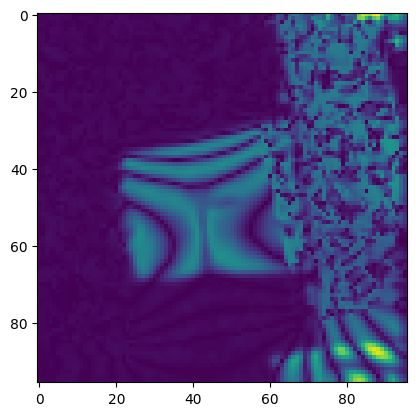

In [25]:
"""Show Complex Augmentation"""

from fastmrt.data.augs import ComplexAugs
from fastmrt.data.dataset import SliceDataset
from fastmrt.utils.fftc import ifft2c_numpy
from fastmrt.utils.trans import real_np_to_complex_np as rn2cn
from fastmrt.data.prf import PrfHeader, PrfFunc
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

data_dir = '../../Datasets/FastMRT Dataset V5.0/phantom/train/source'
sample_idx = 9
seed = 3
dataset = SliceDataset(data_dir, transform=lambda x: x)
augs = ComplexAugs(ca_rate=1.0)

# define prf function
prf_header = PrfHeader(B0=3, gamma=42.576, alpha=0.01, TE=12)
prf_func = PrfFunc(prf_header)

sample = dataset[sample_idx]
image = ifft2c_numpy(sample["kspace"])
image_ref = ifft2c_numpy(sample["kspace_ref"])
tmap = prf_func(image, image_ref)

image_augs, tmap_mask = augs(image, sample["tmap_mask"], seed=seed)
image_augs_ref, _ = augs(image_ref, sample["tmap_mask"], seed=seed)
tmap_augs = prf_func(image_augs, image_augs_ref)
show_sample = {
    "before":{
        "amp": np.abs(image),
        "phs": np.angle(image),
        "tmap": tmap,
    },
    "after":{
        "amp": np.abs(image_augs),
        "phs": np.angle(image_augs),
        "tmap": tmap_augs,
    }
}

# 3. draw single image
'''
 one of :
'''
obj = "image_augs_imag"
plt.clf()
if obj == "image_real":
    plt.imshow(np.abs(image.real))
elif obj == "image_imag":
    plt.imshow(np.abs(image.imag))
elif obj == "image_augs_real":
    plt.imshow(np.angle(image_augs.real))
elif obj == "image_augs_imag":
    plt.imshow(np.abs(image_augs.imag))

plt.show() 

## Draw
# plt.clf()
# fig = plt.figure(figsize=(12, 17))
# fig.subplots_adjust(wspace=0.01, hspace=0.05)
# gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 0.1], height_ratios=[1, 1, 1])
# row_orders = ["amp", "phs", "tmap"]
# col_orders = ["before", "after"]
# row_names = {
#     "amp": "Amplitude", 
#     "phs": "Phase",
#     "tmap": "Temperature Map" 
# }
# col_names = {
#     "before": "Before Complex Augment",
#     "after": "After Complex Augment"
# }
# cmap = ["gray", "coolwarm", "jet"]
# for row_idx, row in enumerate(row_orders):
#     for col_idx, col in enumerate(col_orders):
#         ax = fig.add_subplot(gs[row_idx, col_idx])
#         im = ax.imshow(show_sample[col][row], cmap=cmap[row_idx])

#         if row_idx == 0:
#             ax.set_title(col_names[col], fontsize=18)
#         if col_idx == 0:
#             ax.set_ylabel(row_names[row], fontsize=18)

#         # clear tricks
#         ax.set_xticks([])
#         ax.set_yticks([])
        
#     cax = fig.add_subplot(gs[row_idx, -1])
#     cbar = plt.colorbar(im, cax=cax)
# plt.show()